In [37]:
import os
import sys
import glob
import argparse
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import albumentations as A

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

# Define data paths
train_path = glob.glob('./脑PET图像分析和疾病预测挑战赛公开数据/Train/*/*')
test_path = glob.glob('./脑PET图像分析和疾病预测挑战赛公开数据/Test/*')
np.random.shuffle(train_path)
np.random.shuffle(test_path)

# Define dataset class
class XunFeiDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
    
    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        img = np.array(img)
        
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        img = img.astype(np.float32)
        return img, torch.from_numpy(np.array(int('NC' in self.img_path[index])))

    def __len__(self):
        return len(self.img_path)

# Define data loaders using Albumentations
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[:-10],
        A.Compose([
            A.Resize(128, 128),
            A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ])
    ), batch_size=32, shuffle=True, num_workers=0, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[-10:],
        A.Compose([
            A.Resize(128, 128),
        ])
    ), batch_size=32, shuffle=False, num_workers=0, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path,
        A.Compose([
            A.Resize(128, 128),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
        ])
    ), batch_size=32, shuffle=False, num_workers=0, pin_memory=False
)

# Define custom model
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
        
        model = models.resnet34(True)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # Change input channels
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(512, 2)
        self.resnet = model
        
    def forward(self, img):
        # Add channel dimension
        img = img.unsqueeze(1)
        out = self.resnet(img)
        return out

# Initialize model, move to GPU, and set up loss and optimizer
model = XunFeiNet().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


d:\anaconda1\envs\pytorch\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [39]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True).long()  # Convert target to LongTensor

        output = model(input)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            print(loss.item())

        train_loss += loss.item()

    return train_loss / len(train_loader)

def validate(val_loader, model, criterion):
    model.eval()
    val_acc = 0.0

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda().long()  # Convert target to LongTensor

            output = model(input)
            loss = criterion(output, target)

            val_acc += (output.argmax(1) == target).sum().item()

    return val_acc / len(val_loader.dataset)



In [40]:
for i, (input, target) in enumerate(train_loader):
    print(f"Batch {i + 1}, Input Shape: {input.shape}, Target Shape: {target.shape}")

Batch 1, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 2, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 3, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 4, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 5, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 6, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 7, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 8, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 9, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 10, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 11, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 12, Input Shape: torch.Size([32, 128, 128]), Target Shape: torch.Size([32])
Batch 13, Input Shape: to

0.29012054204940796
0.32924172282218933
Epoch [1/10] - Train Loss: 0.3884 - Train Acc: 0.7438 - Val Acc: 0.9000
0.3687310814857483
0.21675072610378265
Epoch [2/10] - Train Loss: 0.3463 - Train Acc: 0.8297 - Val Acc: 0.9000
0.33473747968673706
0.44381749629974365
Epoch [3/10] - Train Loss: 0.3796 - Train Acc: 0.6750 - Val Acc: 0.7000
0.404375284910202
0.24677467346191406
Epoch [4/10] - Train Loss: 0.3318 - Train Acc: 0.6984 - Val Acc: 0.9000
0.2768430709838867
0.5241744518280029
Epoch [5/10] - Train Loss: 0.3495 - Train Acc: 0.3688 - Val Acc: 0.1000
0.7387133240699768
0.8322542905807495
Epoch [6/10] - Train Loss: 0.3841 - Train Acc: 0.5742 - Val Acc: 0.5000
0.3716236352920532
0.4945809841156006
Epoch [7/10] - Train Loss: 0.3385 - Train Acc: 0.5805 - Val Acc: 0.6000
0.6739892363548279
0.2538764476776123
Epoch [8/10] - Train Loss: 0.2907 - Train Acc: 0.4148 - Val Acc: 0.1000
0.21893703937530518
0.253812313079834
Epoch [9/10] - Train Loss: 0.2596 - Train Acc: 0.6844 - Val Acc: 0.8000
0.455

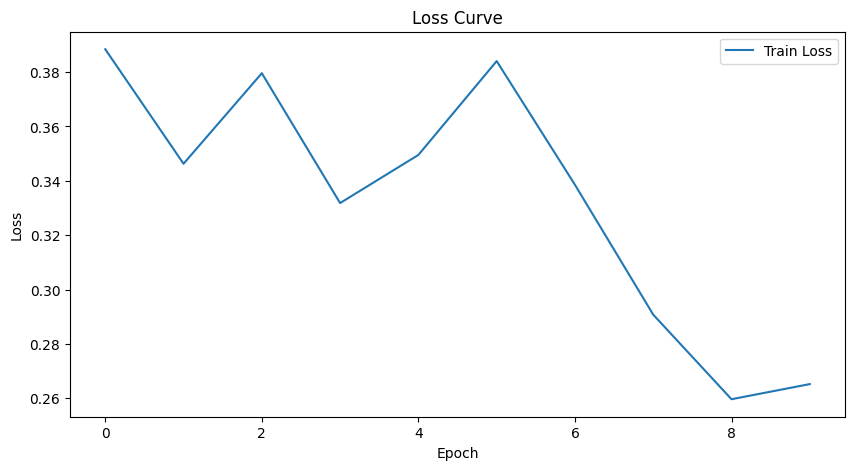

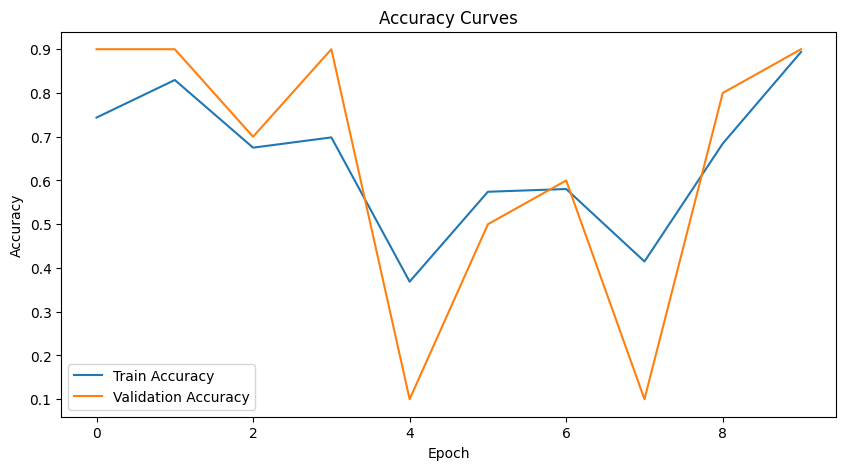

In [42]:
import matplotlib.pyplot as plt
train_losses = []  # 存储每个训练迭代的损失值
train_accs = []    # 存储每个训练迭代的准确率
val_accs = []      # 存储每个验证阶段的准确率

for epoch in range(10):
    train_loss = train(train_loader, model, criterion, optimizer)
    train_acc = validate(train_loader, model, criterion)
    val_acc = validate(val_loader, model, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/10] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

# 绘制损失函数曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 绘制训练集和测试集准确率曲线
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

Fold 1/10
0.8158202171325684
0.6638338565826416
Epoch [1/10] - Train Loss: 0.7579 - Train Acc: 0.7008 - Val Acc: 0.8000
0.527511715888977
0.559128999710083
Epoch [2/10] - Train Loss: 0.5242 - Train Acc: 0.5664 - Val Acc: 0.5000
0.47078585624694824
0.5052574872970581
Epoch [3/10] - Train Loss: 0.5039 - Train Acc: 0.3930 - Val Acc: 0.1000
0.5951846241950989
0.49257296323776245
Epoch [4/10] - Train Loss: 0.5008 - Train Acc: 0.6484 - Val Acc: 0.9000
0.44383424520492554
0.3754268288612366
Epoch [5/10] - Train Loss: 0.4419 - Train Acc: 0.3773 - Val Acc: 0.1000
0.41737082600593567
0.5339874029159546
Epoch [6/10] - Train Loss: 0.4333 - Train Acc: 0.7156 - Val Acc: 0.9000
0.4660438597202301
0.40419626235961914
Epoch [7/10] - Train Loss: 0.4091 - Train Acc: 0.8039 - Val Acc: 1.0000
0.688007652759552
0.6783539652824402
Epoch [8/10] - Train Loss: 0.4137 - Train Acc: 0.6539 - Val Acc: 0.9000
0.488921195268631
0.33599311113357544
Epoch [9/10] - Train Loss: 0.3881 - Train Acc: 0.3727 - Val Acc: 0.100

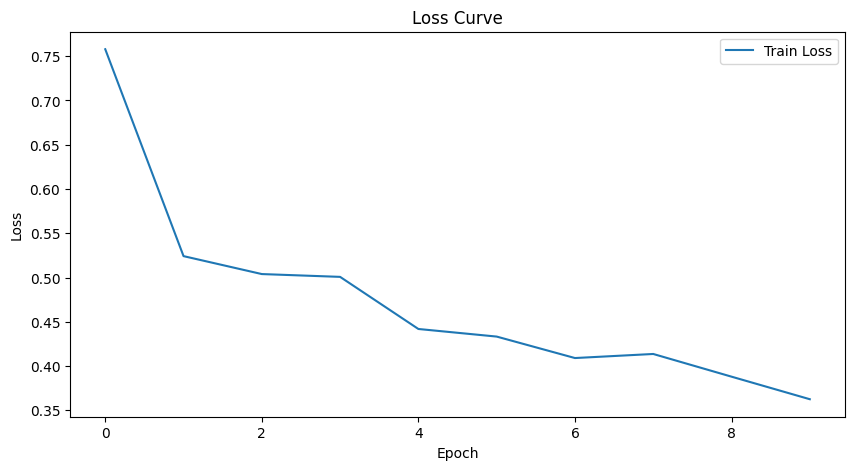

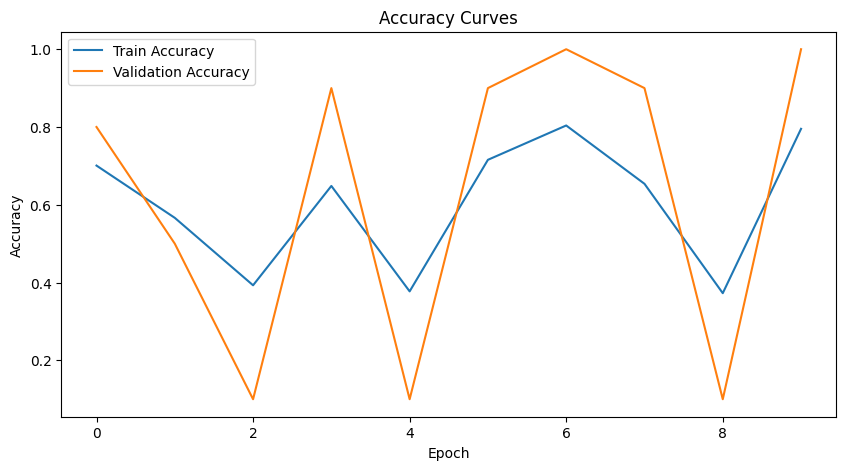

Model saved at ./mode_fold0.pt
Fold 2/10
0.32272595167160034
0.402663916349411
Epoch [1/10] - Train Loss: 0.3471 - Train Acc: 0.4797 - Val Acc: 0.3000
0.303365021944046
0.18283067643642426
Epoch [2/10] - Train Loss: 0.3454 - Train Acc: 0.8273 - Val Acc: 1.0000
0.29485103487968445
0.35182592272758484
Epoch [3/10] - Train Loss: 0.3202 - Train Acc: 0.6523 - Val Acc: 1.0000
0.5137413740158081
0.2708413004875183
Epoch [4/10] - Train Loss: 0.3130 - Train Acc: 0.8430 - Val Acc: 1.0000
0.25131407380104065
0.2793165147304535
Epoch [5/10] - Train Loss: 0.2890 - Train Acc: 0.6773 - Val Acc: 0.9000
0.46619951725006104
0.650260865688324
Epoch [6/10] - Train Loss: 0.2706 - Train Acc: 0.5398 - Val Acc: 0.3000
0.32620447874069214
0.49174314737319946
Epoch [7/10] - Train Loss: 0.2826 - Train Acc: 0.8719 - Val Acc: 0.8000
0.2714005410671234
0.25547125935554504
Epoch [8/10] - Train Loss: 0.2749 - Train Acc: 0.8641 - Val Acc: 1.0000
0.1466161012649536
0.1703944355249405
Epoch [9/10] - Train Loss: 0.2593 -

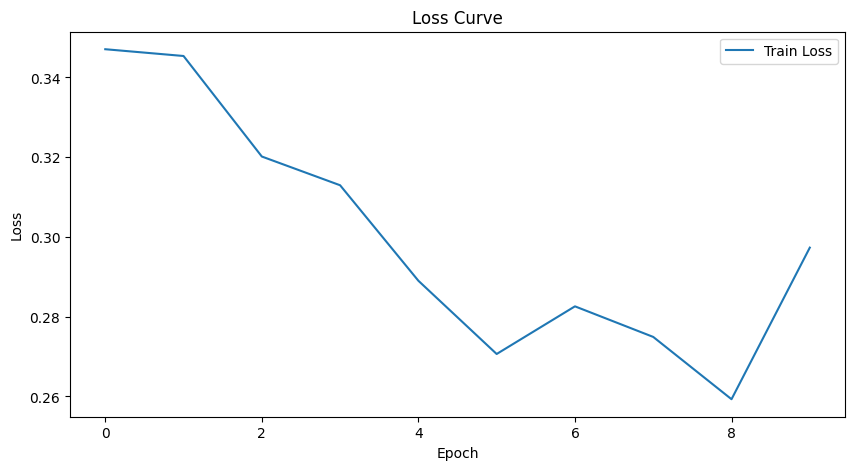

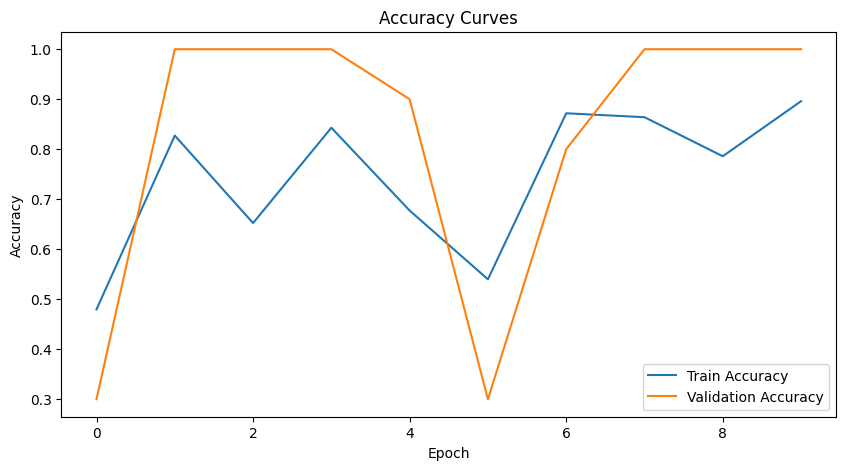

Model saved at ./mode_fold1.pt
Fold 3/10
0.21245336532592773
0.24493521451950073
Epoch [1/10] - Train Loss: 0.2389 - Train Acc: 0.8945 - Val Acc: 1.0000
0.17016710340976715
0.2677256166934967
Epoch [2/10] - Train Loss: 0.2315 - Train Acc: 0.9250 - Val Acc: 1.0000
0.06944295763969421
0.10678637772798538
Epoch [3/10] - Train Loss: 0.2177 - Train Acc: 0.3820 - Val Acc: 0.1000
0.33102187514305115
0.28505900502204895
Epoch [4/10] - Train Loss: 0.2007 - Train Acc: 0.5422 - Val Acc: 0.3000
0.11061855405569077
0.18722178041934967
Epoch [5/10] - Train Loss: 0.1942 - Train Acc: 0.8656 - Val Acc: 1.0000
0.1136615052819252
0.10023748874664307
Epoch [6/10] - Train Loss: 0.2162 - Train Acc: 0.8992 - Val Acc: 1.0000
0.2822624742984772
0.13210369646549225
Epoch [7/10] - Train Loss: 0.1719 - Train Acc: 0.8695 - Val Acc: 0.9000
0.12737606465816498
0.26472699642181396
Epoch [8/10] - Train Loss: 0.1672 - Train Acc: 0.7289 - Val Acc: 0.9000
0.16564494371414185
0.09808318316936493
Epoch [9/10] - Train Loss:

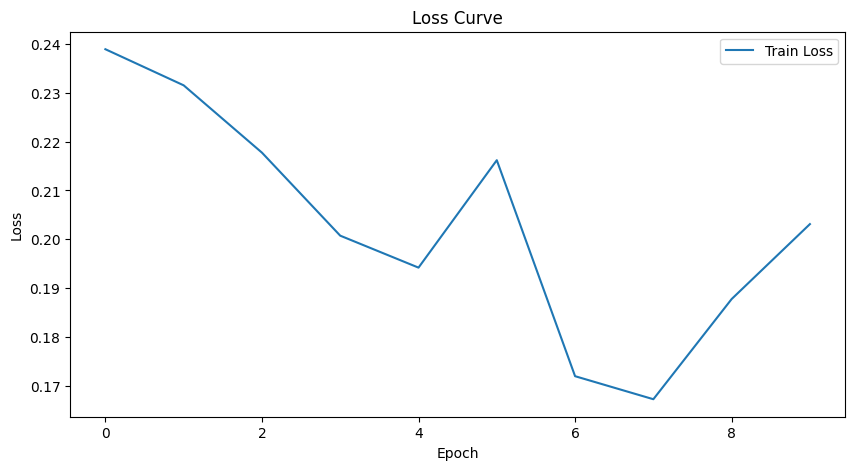

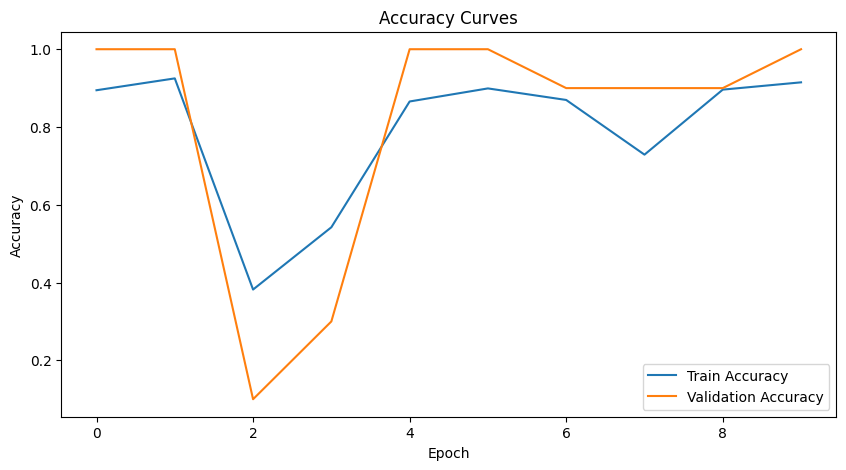

Model saved at ./mode_fold2.pt
Fold 4/10
0.1441039741039276
0.04833390191197395
Epoch [1/10] - Train Loss: 0.1481 - Train Acc: 0.9109 - Val Acc: 0.9000
0.08978641778230667
0.1178198754787445
Epoch [2/10] - Train Loss: 0.1714 - Train Acc: 0.5453 - Val Acc: 0.2000
0.08493100106716156
0.0824134424328804
Epoch [3/10] - Train Loss: 0.1442 - Train Acc: 0.7828 - Val Acc: 0.9000
0.07577942311763763
0.13981953263282776
Epoch [4/10] - Train Loss: 0.1274 - Train Acc: 0.9469 - Val Acc: 1.0000
0.06459087878465652
0.08353205025196075
Epoch [5/10] - Train Loss: 0.1636 - Train Acc: 0.7055 - Val Acc: 0.9000
0.10571233183145523
0.34894174337387085
Epoch [6/10] - Train Loss: 0.1563 - Train Acc: 0.6133 - Val Acc: 0.3000
0.04371700435876846
0.23753727972507477
Epoch [7/10] - Train Loss: 0.1550 - Train Acc: 0.9437 - Val Acc: 1.0000
0.1780751496553421
0.11584386229515076
Epoch [8/10] - Train Loss: 0.1479 - Train Acc: 0.4344 - Val Acc: 0.2000
0.12554292380809784
0.04857247322797775
Epoch [9/10] - Train Loss: 

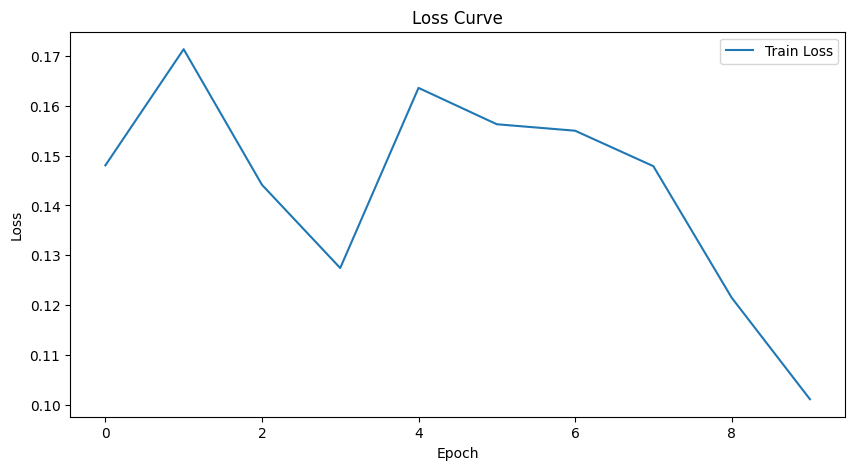

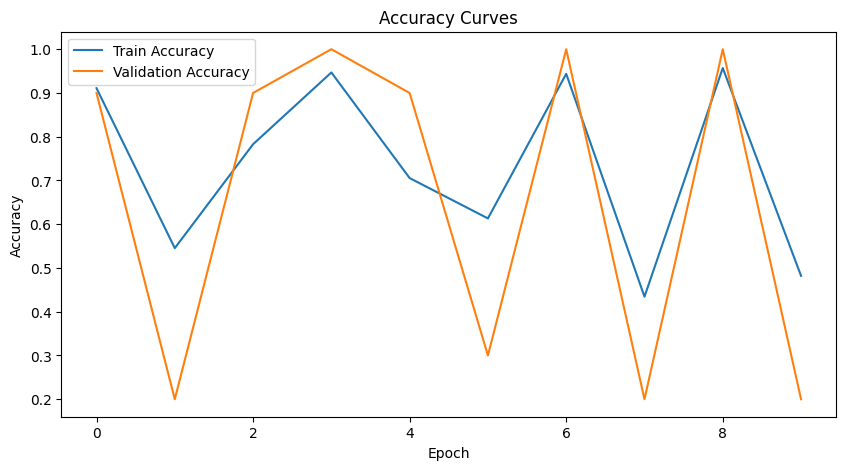

Model saved at ./mode_fold3.pt
Fold 5/10
0.3940117359161377
0.2745865285396576
Epoch [1/10] - Train Loss: 0.1389 - Train Acc: 0.8648 - Val Acc: 0.9000
0.056300900876522064
0.07281161844730377
Epoch [2/10] - Train Loss: 0.0928 - Train Acc: 0.8391 - Val Acc: 0.9000
0.10741519182920456
0.06092161312699318
Epoch [3/10] - Train Loss: 0.1392 - Train Acc: 0.9313 - Val Acc: 1.0000
0.20461483299732208
0.12120794504880905
Epoch [4/10] - Train Loss: 0.1373 - Train Acc: 0.4250 - Val Acc: 0.1000
0.032030586153268814
0.13892583549022675
Epoch [5/10] - Train Loss: 0.1127 - Train Acc: 0.7570 - Val Acc: 0.8000
0.2516116499900818
0.20160406827926636
Epoch [6/10] - Train Loss: 0.1273 - Train Acc: 0.8359 - Val Acc: 0.9000
0.2494381219148636
0.04834568127989769
Epoch [7/10] - Train Loss: 0.0981 - Train Acc: 0.9633 - Val Acc: 1.0000
0.03740935027599335
0.20070631802082062
Epoch [8/10] - Train Loss: 0.0737 - Train Acc: 0.8469 - Val Acc: 0.9000
0.04846973344683647
0.10731139034032822
Epoch [9/10] - Train Loss

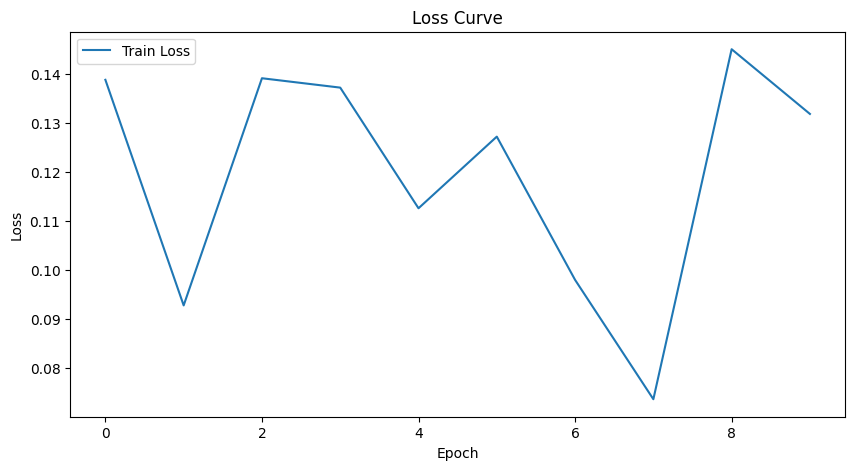

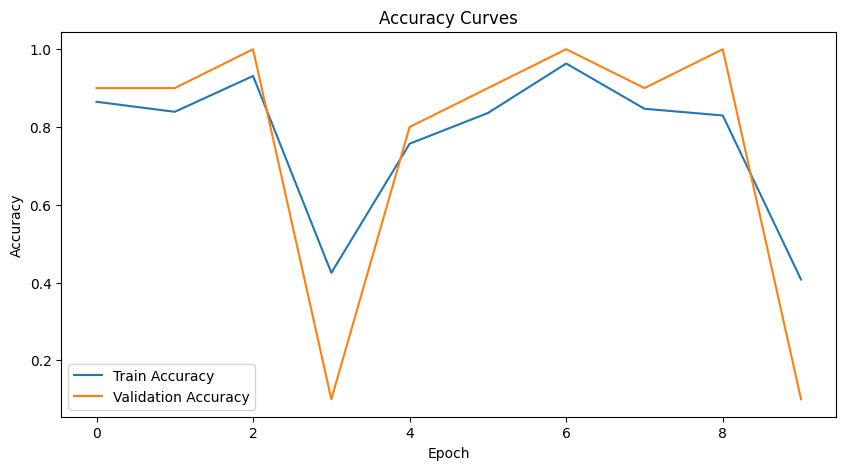

Model saved at ./mode_fold4.pt
Fold 6/10
0.2773660719394684
0.09687785804271698
Epoch [1/10] - Train Loss: 0.1143 - Train Acc: 0.9703 - Val Acc: 1.0000
0.07484161108732224
0.014631493017077446
Epoch [2/10] - Train Loss: 0.0789 - Train Acc: 0.9250 - Val Acc: 1.0000
0.1221783310174942
0.11227941513061523
Epoch [3/10] - Train Loss: 0.1029 - Train Acc: 0.4969 - Val Acc: 0.3000
0.054618217051029205
0.057966966181993484
Epoch [4/10] - Train Loss: 0.0983 - Train Acc: 0.7008 - Val Acc: 0.4000
0.08182504028081894
0.030419792979955673
Epoch [5/10] - Train Loss: 0.0892 - Train Acc: 0.8703 - Val Acc: 1.0000
0.07219967246055603
0.0377335399389267
Epoch [6/10] - Train Loss: 0.1002 - Train Acc: 0.9859 - Val Acc: 1.0000
0.05442269891500473
0.11659959703683853
Epoch [7/10] - Train Loss: 0.0841 - Train Acc: 0.9086 - Val Acc: 1.0000
0.026730891317129135
0.03248155862092972
Epoch [8/10] - Train Loss: 0.0992 - Train Acc: 0.5594 - Val Acc: 0.3000
0.14488092064857483
0.052013419568538666
Epoch [9/10] - Train

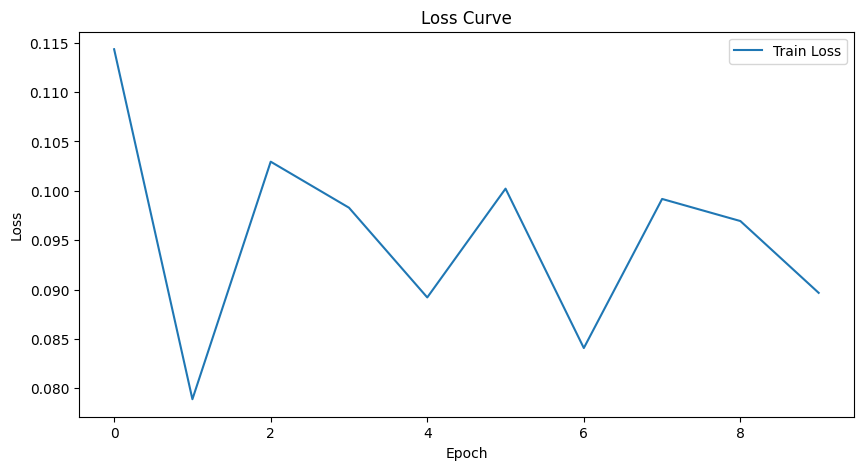

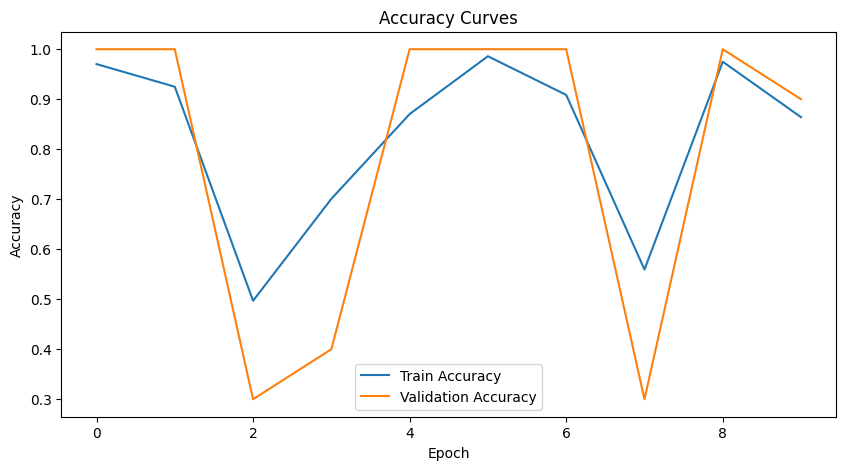

Model saved at ./mode_fold5.pt
Fold 7/10
0.0931897833943367
0.27395716309547424
Epoch [1/10] - Train Loss: 0.0943 - Train Acc: 0.7625 - Val Acc: 0.9000
0.07148277014493942
0.11243467777967453
Epoch [2/10] - Train Loss: 0.0874 - Train Acc: 0.8773 - Val Acc: 1.0000
0.2086503654718399
0.08456351608037949
Epoch [3/10] - Train Loss: 0.0766 - Train Acc: 0.8859 - Val Acc: 1.0000
0.018824826925992966
0.08343517035245895
Epoch [4/10] - Train Loss: 0.0891 - Train Acc: 0.8156 - Val Acc: 0.9000
0.1534321904182434
0.04938022419810295
Epoch [5/10] - Train Loss: 0.0642 - Train Acc: 0.8055 - Val Acc: 1.0000
0.01531852874904871
0.10140450298786163
Epoch [6/10] - Train Loss: 0.0762 - Train Acc: 0.9555 - Val Acc: 1.0000
0.008528395555913448
0.0037549911066889763
Epoch [7/10] - Train Loss: 0.0499 - Train Acc: 0.8063 - Val Acc: 1.0000
0.05049203336238861
0.013233203440904617
Epoch [8/10] - Train Loss: 0.0702 - Train Acc: 0.7438 - Val Acc: 0.9000
0.024414626881480217
0.024251321330666542
Epoch [9/10] - Trai

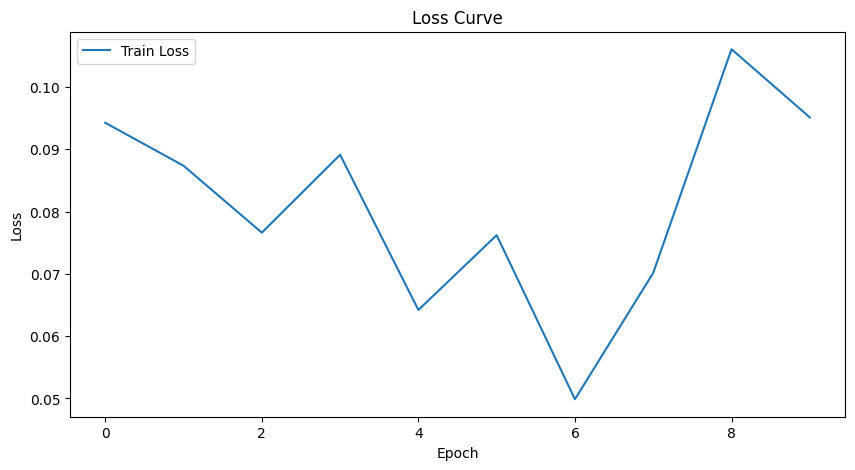

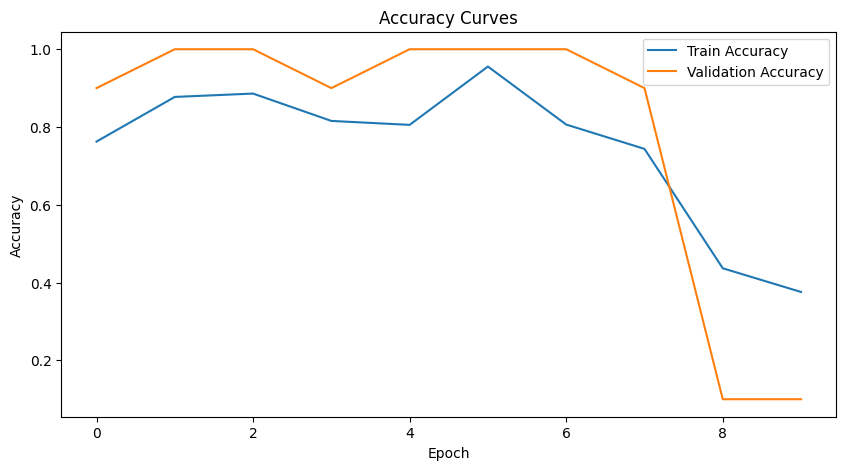

Model saved at ./mode_fold6.pt
Fold 8/10
0.037492524832487106
0.07543867081403732
Epoch [1/10] - Train Loss: 0.1862 - Train Acc: 0.4555 - Val Acc: 0.1000
0.23458249866962433
0.05192634090781212
Epoch [2/10] - Train Loss: 0.1143 - Train Acc: 0.7000 - Val Acc: 0.4000
0.03523460030555725
0.06511619687080383
Epoch [3/10] - Train Loss: 0.1188 - Train Acc: 0.9039 - Val Acc: 0.9000
0.08560305088758469
0.06387719511985779
Epoch [4/10] - Train Loss: 0.0721 - Train Acc: 0.9781 - Val Acc: 1.0000
0.10440586507320404
0.15824109315872192
Epoch [5/10] - Train Loss: 0.1049 - Train Acc: 0.8484 - Val Acc: 0.9000
0.10335733741521835
0.0116469357162714
Epoch [6/10] - Train Loss: 0.0774 - Train Acc: 0.5289 - Val Acc: 0.2000
0.16621047258377075
0.021247806027531624
Epoch [7/10] - Train Loss: 0.0809 - Train Acc: 0.4383 - Val Acc: 0.2000
0.00931132398545742
0.028874676674604416
Epoch [8/10] - Train Loss: 0.0531 - Train Acc: 0.8086 - Val Acc: 0.8000
0.01144262682646513
0.034595243632793427
Epoch [9/10] - Train

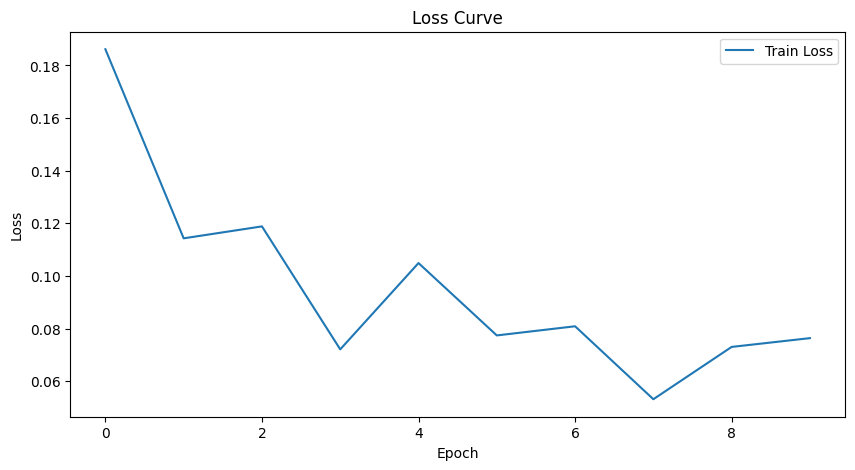

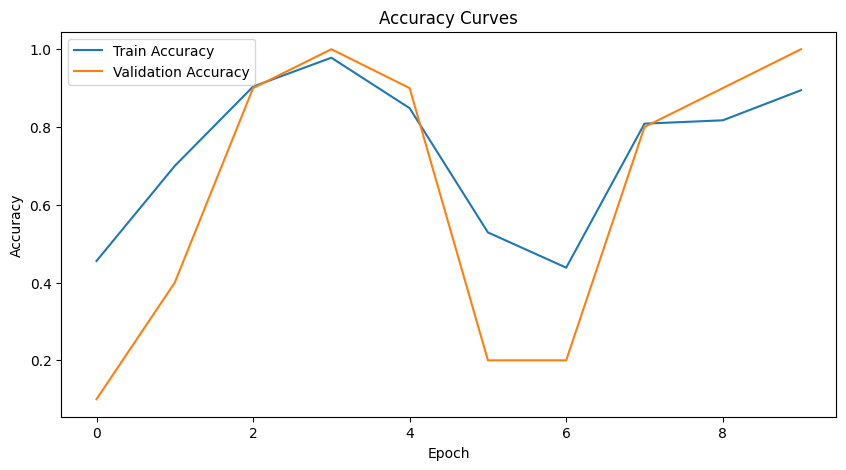

Model saved at ./mode_fold7.pt
Fold 9/10
0.04577987268567085
0.04420563206076622
Epoch [1/10] - Train Loss: 0.0507 - Train Acc: 0.8695 - Val Acc: 1.0000
0.11448155343532562
0.01730932667851448
Epoch [2/10] - Train Loss: 0.0486 - Train Acc: 0.9672 - Val Acc: 1.0000
0.040845949202775955
0.05990146845579147
Epoch [3/10] - Train Loss: 0.0794 - Train Acc: 0.7266 - Val Acc: 0.5000
0.03232146427035332
0.020315436646342278
Epoch [4/10] - Train Loss: 0.0411 - Train Acc: 0.8086 - Val Acc: 0.9000
0.06699680536985397
0.04019739478826523
Epoch [5/10] - Train Loss: 0.0997 - Train Acc: 0.9078 - Val Acc: 1.0000
0.09088126569986343
0.08042224496603012
Epoch [6/10] - Train Loss: 0.0584 - Train Acc: 0.7750 - Val Acc: 0.9000
0.06668510288000107
0.16021528840065002
Epoch [7/10] - Train Loss: 0.1117 - Train Acc: 0.7625 - Val Acc: 1.0000
0.3695453703403473
0.016698312014341354
Epoch [8/10] - Train Loss: 0.0820 - Train Acc: 0.9391 - Val Acc: 1.0000
0.025447780266404152
0.008496154099702835
Epoch [9/10] - Trai

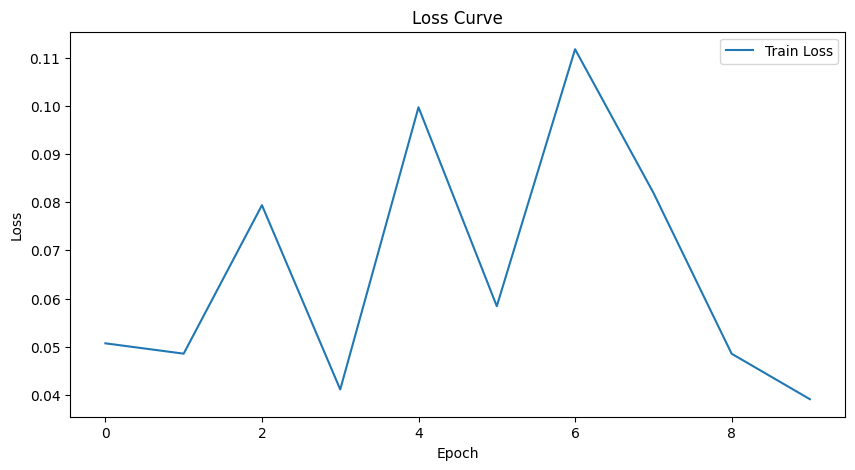

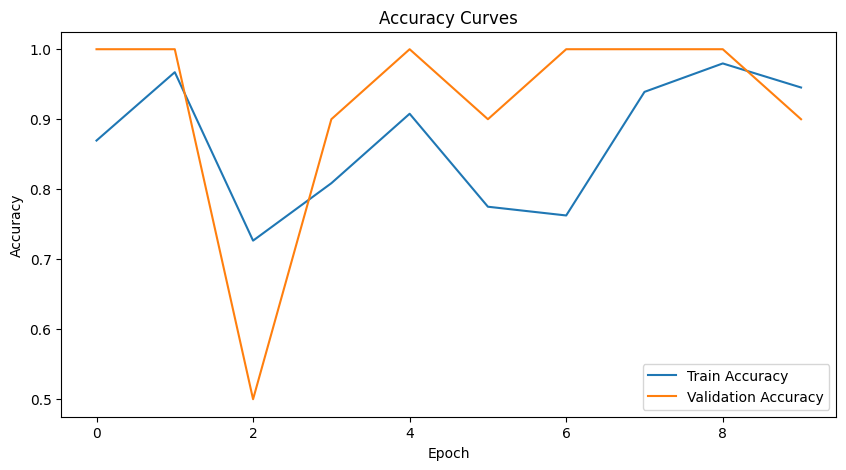

Model saved at ./mode_fold8.pt
Fold 10/10
0.006997537799179554
0.01932978630065918
Epoch [1/10] - Train Loss: 0.0493 - Train Acc: 0.6266 - Val Acc: 0.4000
0.27552875876426697
0.014706794172525406
Epoch [2/10] - Train Loss: 0.0665 - Train Acc: 0.9469 - Val Acc: 0.9000
0.019665176048874855
0.012698282487690449
Epoch [3/10] - Train Loss: 0.0327 - Train Acc: 0.9344 - Val Acc: 1.0000
0.023691948503255844
0.018010664731264114
Epoch [4/10] - Train Loss: 0.0641 - Train Acc: 0.9820 - Val Acc: 1.0000
0.0603693425655365
0.15639126300811768
Epoch [5/10] - Train Loss: 0.0346 - Train Acc: 0.6961 - Val Acc: 0.9000
0.025584759190678596
0.00458300206810236
Epoch [6/10] - Train Loss: 0.0520 - Train Acc: 0.9484 - Val Acc: 1.0000
0.006425629369914532
0.009617728181183338
Epoch [7/10] - Train Loss: 0.0431 - Train Acc: 0.7773 - Val Acc: 1.0000
0.0056485761888325214
0.02991635724902153
Epoch [8/10] - Train Loss: 0.0484 - Train Acc: 0.9070 - Val Acc: 1.0000
0.002895006909966469
0.06600316613912582
Epoch [9/10

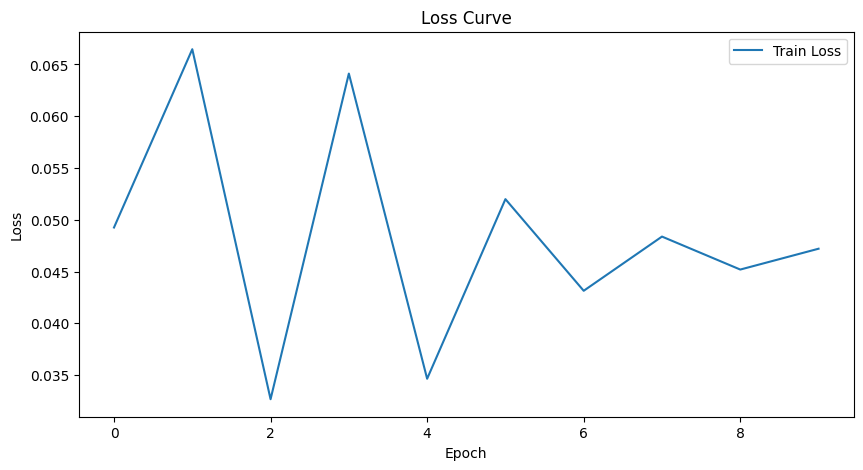

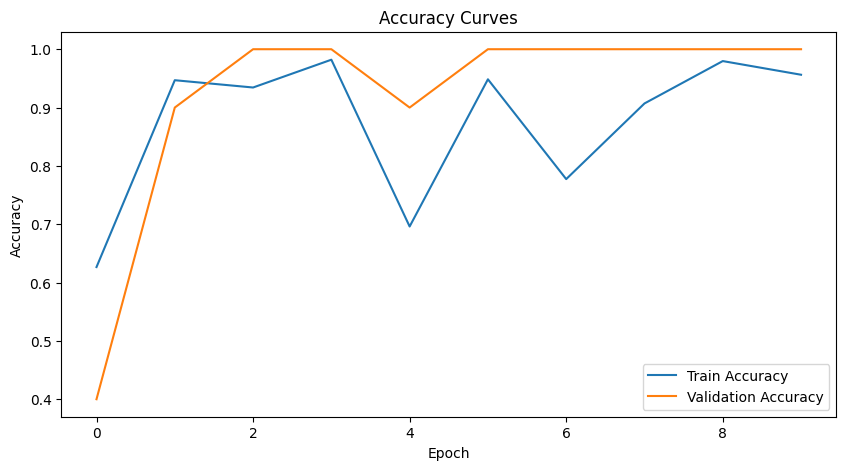

Model saved at ./mode_fold9.pt


In [69]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
skf = KFold(n_splits=10, random_state=233, shuffle=True)

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_path, train_path)):
    print(f"Fold {fold_idx + 1}/{skf.get_n_splits()}")
    
    # Define data loaders using Albumentations
    train_loader = torch.utils.data.DataLoader(
        XunFeiDataset(train_path[:-10],
            A.Compose([
                A.Resize(128, 128),
                A.RandomRotate90(),
                A.HorizontalFlip(p=0.5),
                A.RandomContrast(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
            ])
        ), batch_size=32, shuffle=True, num_workers=0, pin_memory=False
    )

    val_loader = torch.utils.data.DataLoader(
        XunFeiDataset(train_path[-10:],
            A.Compose([
                A.Resize(128, 128),
            ])
        ), batch_size=32, shuffle=False, num_workers=0, pin_memory=False
    )


    train_losses = []  # 存储每个训练迭代的损失值
    train_accs = []    # 存储每个训练迭代的准确率
    val_accs = []      # 存储每个验证阶段的准确率
    
    for epoch in range(10):
        train_loss = train(train_loader, model, criterion, optimizer)
        train_acc = validate(train_loader, model, criterion)
        val_acc = validate(val_loader, model, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/10] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # 绘制损失函数曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    # 绘制训练集和测试集准确率曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.show()
        
    # Save the trained model
    model_save_path = f'./mode_fold{fold_idx}.pt'
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}")


这段代码实现了一个简单的训练和验证循环来训练和评估神经网络模型。以下是代码的主要功能和流程：

1. `train` 函数：
   - 设置模型为训练模式（`model.train()`）。
   - 初始化一个变量 `train_loss` 用于累积每个 batch 的训练损失。
   - 在训练数据加载器上进行循环（`train_loader` 包含训练数据和标签）。
   - 将输入数据和标签转移到 GPU 上（使用 `cuda(non_blocking=True)`）。
   - 将输入数据传递给模型，得到输出。
   - 计算预测输出与真实标签之间的损失，这里使用交叉熵损失函数（`criterion(output, target)`）。
   - 清零优化器的梯度信息（`optimizer.zero_grad()`）。
   - 执行反向传播计算梯度（`loss.backward()`）。
   - 使用优化器更新模型参数（`optimizer.step()`）。
   - 在每个 20 个 batch 后，打印当前 batch 的损失。
   - 累加每个 batch 的损失到 `train_loss` 中。
   - 返回平均训练损失。

2. `validate` 函数：
   - 设置模型为评估模式（`model.eval()`）。
   - 初始化一个变量 `val_acc` 用于累积验证集的预测正确数量。
   - 在验证数据加载器上进行循环（`val_loader` 包含验证数据和标签）。
   - 将输入数据和标签转移到 GPU 上。
   - 将输入数据传递给模型，得到输出。
   - 计算预测输出与真实标签之间的损失。
   - 判断每个样本的预测类别是否与真实类别相符，将匹配的数量累加到 `val_acc` 中。
   - 返回验证集上的准确率（正确预测的样本数除以验证集总样本数）。

3. 主循环：
   - 使用一个循环来重复训练和验证的过程，循环3次（`for _ in range(3):`）。
   - 在每次循环中，首先调用 `train` 函数训练模型并获得训练损失。
   - 然后分别调用 `validate` 函数计算训练集和验证集上的准确率。
   - 最后，打印当前循环中的训练损失、训练集准确率和验证集准确率。

总之，这段代码实现了一个基本的神经网络训练和验证过程，用于训练模型并监控训练和验证的性能。在每次循环中，模型的参数通过优化器进行更新，然后通过计算损失和准确率来监控模型的性能。

------------------------------
根据你提供的代码，我注意到一些潜在的问题。首先，我注意到在数据加载的时候，你将目标标签从 NumPy 数组转换为 PyTorch 张量时，并没有明确地指定数据类型。这可能导致数据类型不匹配的问题。我建议你在这一步明确地指定数据类型为 torch.long，即 LongTensor。另外，你需要将目标标签从原始标签编码（例如 'NC' 或其他类别）转换为整数标签。

------------------------
在你的代码中，你使用了 Windows 系统路径分隔符 \，而在类 Unix 系统中，通常使用 / 作为路径分隔符。因此，当你尝试将类似 Test\98 这样的路径字符串进行切割和转换时，会导致 int() 函数失败，因为其中包含了非数字字符。

为了解决这个问题，你可以考虑使用 Python 的 os.path 模块来处理路径，以确保路径分隔符的一致性。具体做法如下：

权重可视化： 可以查看卷积层的权重，了解模型学到的特征。

In [5]:
def predict(test_loader, model, criterion):
    model.eval()
    test_pred = []
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            output = model(input)
            test_pred.append(output.data.cpu().numpy())

    return np.vstack(test_pred)

# List of model paths
model_paths = ['mode_fold1.pt']

# Initialize tqdm for model loop
model_loop = tqdm(model_paths, desc="Models")

# Initialize pred variable
pred = None

for model_path in model_loop:
    model = XunFeiNet()
    model = model.to('cuda')
    model.load_state_dict(torch.load(model_path))

    # Initialize tqdm for inference loop
    inference_loop = tqdm(range(10), desc="Inference", leave=False)

    for _ in inference_loop:
        if pred is None:
            pred = predict(test_loader, model, criterion)
        else:
            pred += predict(test_loader, model, criterion)
        
        inference_loop.set_postfix({"Avg. Prediction": np.mean(pred)})

# Average the accumulated predictions
pred /= len(model_paths * 10)  # Assuming 10 predictions per model

# Convert predictions to labels
predicted_labels = np.argmax(pred, axis=1)
label_mapping = {1: 'NC', 0: 'MCI'}
predicted_labels = [label_mapping[label] for label in predicted_labels]

# Create a submission DataFrame
submit = pd.DataFrame({
    'uuid': [int(x.split('\\')[-1][:-4]) for x in test_path],  # Make sure test_path is defined
    'label': predicted_labels
})

# Sort the DataFrame by 'uuid'
submit = submit.sort_values(by='uuid')

# Save the submission CSV
submit.to_csv('submit1_6.csv', index=None)


Models:   0%|          | 0/1 [01:13<?, ?it/s]


KeyboardInterrupt: 

In [46]:
from collections import Counter
from tqdm import tqdm

# Define the path to your model checkpoint
model_path = 'mode_fold8.pt'

# Load the model checkpoint
model = XunFeiNet()
model = model.to('cuda')
model.load_state_dict(torch.load(model_path))
model.eval()

def predict_majority(test_loader, model):
    model.eval()
    test_pred = []

    with torch.no_grad():
        for input, _ in test_loader:
            input = input.cuda()
            output = model(input)
            test_pred.append(output.cpu())  # No need for .data.numpy() here

    return torch.cat(test_pred, dim=0)  # Concatenate along batch dimension

# Get model predictions
pred = predict_majority(test_loader, model)

# Calculate predicted labels
predicted_labels = pred.argmax(dim=1)
predicted_labels = predicted_labels.tolist()

# Create a dictionary to store NC and MCI counts for each slice
slice_counts = {}
for i, path in enumerate(test_path):
    slice_name = path.split('/')[-1]
    slice_num = slice_name.split('_')[1]
    label = predicted_labels[i]

    if slice_num not in slice_counts:
        slice_counts[slice_num] = Counter()

    slice_counts[slice_num][label] += 1

# Create a dictionary to store predictions for each sample
sample_predictions = {}

# Fill in sample_predictions with individual predictions
for i, (input, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
    input = input.cuda()
    output = model(input)
    predicted_scores = output.cpu().tolist()  # Get prediction scores instead of labels
    
    slice_names = [path.split('\\')[-1] for path in test_path[i * 32 : (i + 1) * 32]]
    sample_ids = [name.split('_')[0] for name in slice_names]
    
    for j, sample_id in enumerate(sample_ids):
        if sample_id not in sample_predictions:
            sample_predictions[sample_id] = []
        sample_predictions[sample_id].append(predicted_scores[j])

# Determine majority label for each sample
final_predictions = []
sorted_sample_predictions = sorted(sample_predictions.items(), key=lambda x: int(x[0]))

for sample_id, scores_list in sorted_sample_predictions:
    avg_scores = np.mean(scores_list, axis=0)  # Calculate average scores across slices
    predicted_label = np.argmax(avg_scores)  # Choose the class with the highest average score
    
    # Assuming predicted_label 0 corresponds to "NC" and predicted_label 1 corresponds to "MCI"
    if predicted_label == 0:
        final_predictions.append('NC')
    else:
        final_predictions.append('MCI')

# Create submission DataFrame
submit = pd.DataFrame(
    {
        'uuid': [int(sample_id) for sample_id, _ in sorted_sample_predictions],
        'label': final_predictions
    }
)
submit.to_csv('submit1.csv', index=None)

d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 107/107 [00:03<00:00, 31.61it/s]


In [44]:
from collections import Counter
from tqdm import tqdm

def predict_majority(test_loader, model):
    model.eval()
    test_pred = []

    with torch.no_grad():
        for input, _ in test_loader:
            input = input.cuda()
            output = model(input)
            test_pred.append(output.cpu())  # No need for .data.numpy() here

    return torch.cat(test_pred, dim=0)  # Concatenate along batch dimension

# Get model predictions
pred = predict_majority(test_loader, model)

# Calculate predicted labels
predicted_labels = pred.argmax(dim=1)
predicted_labels = predicted_labels.tolist()

# Create a dictionary to store NC and MCI counts for each slice
slice_counts = {}
for i, path in enumerate(test_path):
    slice_name = path.split('/')[-1]
    slice_num = slice_name.split('_')[1]
    label = predicted_labels[i]

    if slice_num not in slice_counts:
        slice_counts[slice_num] = Counter()

    slice_counts[slice_num][label] += 1

# Create a dictionary to store predictions for each sample
sample_predictions = {}

# Fill in sample_predictions with individual predictions
for i, (input, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
    input = input.cuda()
    output = model(input)
    predicted_scores = output.cpu().tolist()  # Get prediction scores instead of labels
    
    slice_names = [path.split('\\')[-1] for path in test_path[i * 32 : (i + 1) * 32]]
    sample_ids = [name.split('_')[0] for name in slice_names]
    
    for j, sample_id in enumerate(sample_ids):
        if sample_id not in sample_predictions:
            sample_predictions[sample_id] = []
        sample_predictions[sample_id].append(predicted_scores[j])

# Determine majority label for each sample
final_predictions = []
sorted_sample_predictions = sorted(sample_predictions.items(), key=lambda x: int(x[0]))

for sample_id, scores_list in sorted_sample_predictions:
    avg_scores = np.mean(scores_list, axis=0)  # Calculate average scores across slices
    predicted_label = np.argmax(avg_scores)  # Choose the class with the highest average score
    
    # Assuming predicted_label 0 corresponds to "NC" and predicted_label 1 corresponds to "MCI"
    if predicted_label == 0:
        final_predictions.append('NC')
    else:
        final_predictions.append('MCI')
print(sorted_sample_predictions)

# Create submission DataFrame
submit = pd.DataFrame(
    {
        'uuid': [int(sample_id) for sample_id, _ in sorted_sample_predictions],
        'label': final_predictions
    }
)
submit.to_csv('submit.csv', index=None)


100%|██████████| 107/107 [00:03<00:00, 31.53it/s]


[('1', [[-2.9009268283843994, 3.50911545753479], [1.5504337549209595, -1.5157991647720337], [0.9410844445228577, -0.8738641738891602], [1.092810034751892, -1.0768548250198364], [-0.7388869524002075, 0.8820555806159973], [-0.08773142844438553, 0.23609909415245056], [-0.5897203683853149, 0.7293016910552979], [-1.0032838582992554, 1.162666916847229], [1.5010027885437012, -1.4822086095809937], [0.5589147210121155, -0.3737206757068634], [1.9423099756240845, -1.957093596458435], [1.497088074684143, -1.3826193809509277], [-0.5150244832038879, 0.7227111458778381], [1.6208685636520386, -1.5137571096420288], [-2.179863214492798, 2.521003007888794], [-0.16396236419677734, 0.343205988407135], [-0.41981789469718933, 0.5985466837882996], [0.5712743997573853, -0.47920840978622437], [0.4464237689971924, -0.40547218918800354], [1.26182222366333, -1.1907707452774048], [-1.953452229499817, 2.284360408782959]]), ('2', [[0.001717221923172474, 0.09300679713487625], [-1.0005545616149902, 1.2349740266799927],

In [45]:
# Sort test paths to match file order
test_path_sorted = sorted(test_path, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Create a dictionary to map class labels to their meanings
class_labels = {0: 'MCI', 1: 'NC'}

# Collect slice predictions for each sample
sample_slices = {}

# Fill in sample_slices with individual slice predictions
for i, (input, _) in tqdm(enumerate(test_loader), total=len(test_loader)):  # Use tqdm here
    input = input.cuda()
    output = model(input)
    predicted_labels = output.argmax(dim=1).cpu().tolist()
    
    slice_names = [path.split('\\')[-1] for path in test_path[i * 32 : (i + 1) * 32]]
    sample_ids = [name.split('_')[0] for name in slice_names]
    
    for j, sample_id in enumerate(sample_ids):
        if sample_id not in sample_slices:
            sample_slices[sample_id] = []
        sample_slices[sample_id].append(predicted_labels[j])

# Print predictions for each sample and slice in order
for sample_id, predictions in sorted(sample_slices.items(), key=lambda x: int(x[0])):
    for slice_index, prediction in enumerate(predictions, start=1):
        slice_name = f"{sample_id}_{slice_index}.png"
        slice_num = slice_index
        label_str = class_labels[prediction]
        
        print(f"Slice {slice_num}: Original File Name - {slice_name}, Predicted Label - {label_str}")

100%|██████████| 107/107 [00:03<00:00, 29.27it/s]

Slice 1: Original File Name - 1_1.png, Predicted Label - NC
Slice 2: Original File Name - 1_2.png, Predicted Label - MCI
Slice 3: Original File Name - 1_3.png, Predicted Label - MCI
Slice 4: Original File Name - 1_4.png, Predicted Label - MCI
Slice 5: Original File Name - 1_5.png, Predicted Label - NC
Slice 6: Original File Name - 1_6.png, Predicted Label - NC
Slice 7: Original File Name - 1_7.png, Predicted Label - NC
Slice 8: Original File Name - 1_8.png, Predicted Label - NC
Slice 9: Original File Name - 1_9.png, Predicted Label - MCI
Slice 10: Original File Name - 1_10.png, Predicted Label - NC
Slice 11: Original File Name - 1_11.png, Predicted Label - MCI
Slice 12: Original File Name - 1_12.png, Predicted Label - MCI
Slice 13: Original File Name - 1_13.png, Predicted Label - MCI
Slice 14: Original File Name - 1_14.png, Predicted Label - MCI
Slice 15: Original File Name - 1_15.png, Predicted Label - NC
Slice 16: Original File Name - 1_16.png, Predicted Label - NC
Slice 17: Original

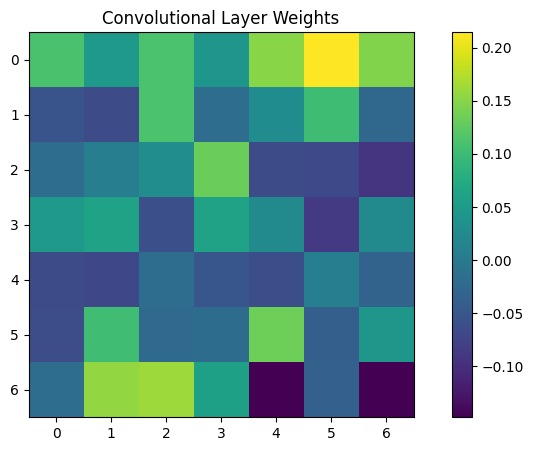

In [71]:
import matplotlib.pyplot as plt

def plot_weights(layer):
    weights = layer.weight.data.cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(weights[0, 0], cmap='viridis')
    plt.colorbar()
    plt.title("Convolutional Layer Weights")
    plt.show()

# Example usage
conv_layer = model.resnet.conv1  # Get a convolutional layer from your model
plot_weights(conv_layer)


模型架构可视化